<a href="https://colab.research.google.com/github/Nub-T/Noob_Computation/blob/main/DeepLearning_Frame_Work_using_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Coded by : Yehezk34</b>

In [6]:
import matplotlib
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import make_moons, make_circles 
from sklearn.metrics import roc_auc_score

In [7]:
# Frame work is full of classes, so first we have to create any deep learning framework classes!
class Model:
    def __init__(self):
        self.layers = []
        self.loss = []
     
    def add(self, layer):
        self.layers.append(layer)
     
    def predict(self, X):
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(X)
            X = forward
        return forward
     
    def train(
        self, 
        X_train, 
        Y_train, 
        learning_rate, 
        epochs, 
        verbose=False
    ):
        for epoch in range(epochs):
            loss = self._run_epoch(X_train, Y_train, learning_rate)
            if verbose:
                if epoch % 50 == 0:
                    print(f'Epoch: {epoch}. Loss: {loss}')
     
    def _run_epoch(self, X, Y, learning_rate):
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(input_val=X)
            X = forward
        bce = BinaryCrossEntropy(forward, Y)
        error = bce.forward()
        gradient = bce.backward()
        self.loss.append(error)
         
        # Backpropagation
        for i, _ in reversed(list(enumerate(self.layers))):
            if self.layers[i].type != 'Linear':
                gradient = self.layers[i].backward(gradient)
            else:
                gradient, dW, dB = self.layers[i].backward(gradient)
                self.layers[i].optimize(dW, dB, learning_rate)
                 
        return error # Notice that we don’t actually need the error in backpropagation, just the gradient. We use the error to see how far we are from our objective.

In [8]:
class Layer:
    def __init__(self):
        pass
     
    def __len__(self):
        pass
     
    def __str__(self):
        pass
     
    def forward(self):
        pass
     
    def backward(self):
        pass
     
    def optimize(self):
        pass
 
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.rand(output_dim, input_dim)
        self.biases = np.random.rand(output_dim, 1)
        self.type = 'Linear'
 
    def __str__(self):
        return f"{self.type} Layer"
         
    def forward(self, input_val):
        self._prev_acti = input_val
        return np.matmul(self.weights, input_val) + self.biases
     
    def backward(self, dA):
        dW = np.dot(dA, self._prev_acti.T)
        dB = dA.mean(axis=1, keepdims=True)
         
        delta = np.dot(self.weights.T, dA)
         
        return delta, dW, dB
     
    def optimize(self, dW, dB, rate):
        self.weights = self.weights - rate * dW
        self.biases = self.biases - rate * dB
 
class ReLU(Layer):    
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = 'ReLU'
 
    def __str__(self):
        return f"{self.type} Layer"       
         
    def forward(self, input_val):
        self._prev_acti = np.maximum(0, input_val)
        return self._prev_acti
     
    def backward(self, dJ):
        return dJ * np.heaviside(self._prev_acti, 0)
 
class Sigmoid(Layer):
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = 'Sigmoid'
 
    def __str__(self):
        return f"{self.type} Layer"       
         
    def forward(self, input_val):
        self._prev_acti = 1 / (1 + np.exp(-input_val))
        return self._prev_acti
     
    def backward(self, dJ):
        sig = self._prev_acti
        return dJ * sig * (1 - sig)

To calculate the error, we have a lot of options. Probably, the most basic one is the Mean Squared Error we saw earlier. I have added another one called Binary Cross-Entropy (the one that is in the code) because we will test our model using the latter in the following sections.

In [9]:
class MeanSquaredError(Layer):
    def __init__(self, predicted, real):
        self.predicted = predicted
        self.real = real
        self.type = 'Mean Squared Error'
     
    def forward(self):
        return np.power(self.predicted - self.real, 2).mean()
 
    def backward(self):
        return 2 * (self.predicted - self.real).mean()
 
class BinaryCrossEntropy(Layer):
    def __init__(self, predicted, real):
        self.real = real
        self.predicted = predicted
        self.type = 'Binary Cross-Entropy'
     
    def forward(self):
        n = len(self.real)
        loss = np.nansum(-self.real * np.log(self.predicted) - (1 - self.real) * np.log(1 - self.predicted)) / n
         
        return np.squeeze(loss)
     
    def backward(self):
        n = len(self.real)
        return (-(self.real / self.predicted) + ((1 - self.real) / (1 - self.predicted))) / n

The layers can compute in 2 directions: forward and backward. This is an inherited behaviour from the computational graphs design, and it makes computationally easier to calculate the derivatives. In fact, we could have split the Linear layer into “multiply and “add” classes, as TensorFlow does it.<br>The weights and biases are initialized using a uniform distribution. There are other ways to initialize these parameters, like kaiming initialization.

In [10]:
# Once we compute the gradient on the last layer, we backpropagate it by multiplying the corresponding derivatives of the actual layer with the incoming gradient of the following layer.
# Now, we generate example data!
def generate_data(samples, shape_type='circles', noise=0.05):
    if shape_type is 'moons':
        X, Y = make_moons(n_samples=samples, noise=noise)
    elif shape_type is 'circles':
        X, Y = make_circles(n_samples=samples, noise=noise)
    else:
        raise ValueError(f"The introduced shape {shape_type} is not valid. Please use 'moons' or 'circles' ")
    data = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    return data

def plot_generated_data(data):
    ax = data.plot.scatter(x='x', y='y', figsize=(16,12), color=data['label'], 
                 cmap=matplotlib.colors.ListedColormap(['skyblue', 'salmon']), grid=True);
    return ax

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:227: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"


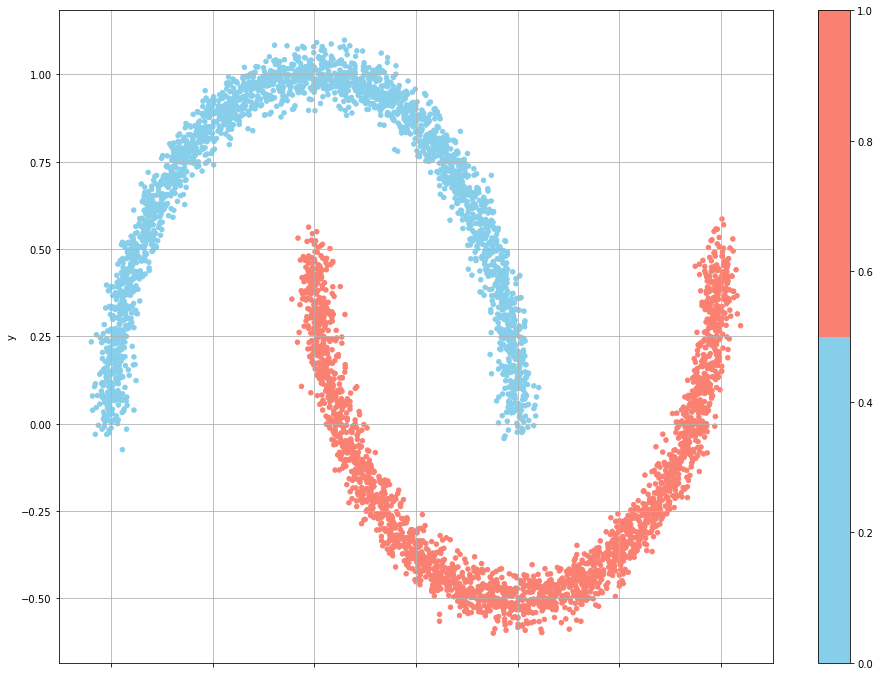

In [11]:
data = generate_data(samples=5000, shape_type='moons', noise=0.04)
plot_generated_data(data);

In [12]:
X = data[['x', 'y']].values
Y = data['label'].T.values

In [20]:
# Here, we create the model!
model = Model()
model.add(Linear(2, 5))
model.add(ReLU(5))
 
model.add(Linear(5,5))
model.add(ReLU(5))
 
model.add(Linear(5,1))
model.add(Sigmoid(1))

# Train model
model.train(X_train = X.T, 
            Y_train = Y, 
            learning_rate = 0.05, 
            epochs=1000,
            verbose=False)

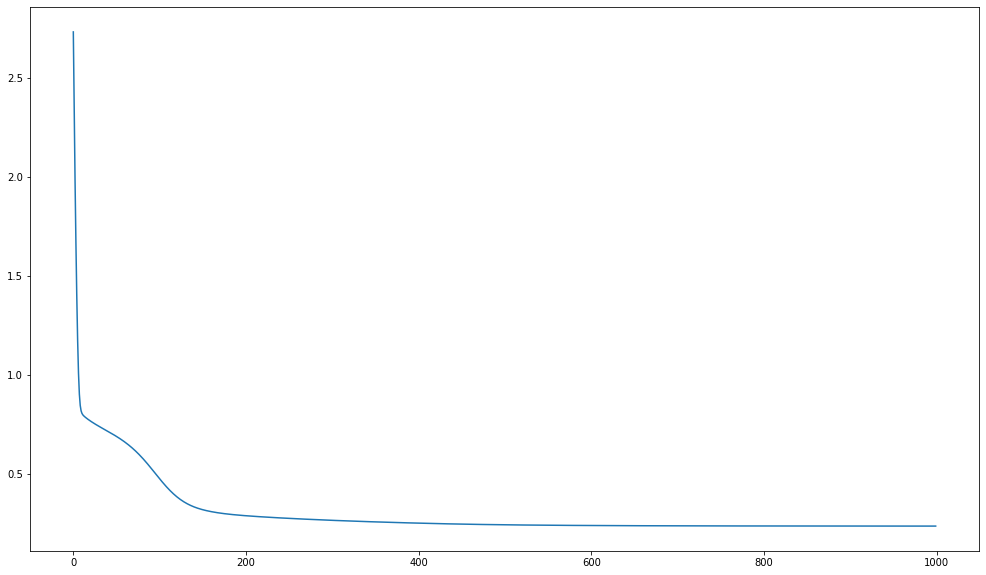

In [21]:
# Plot the loss!
plt.figure(figsize=(17,10))
plt.plot(model.loss)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd0bdca470>)

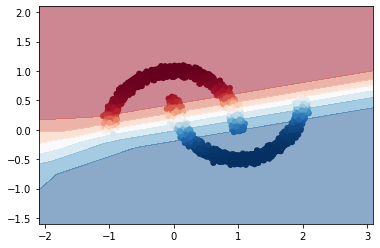

In [22]:
# Predict the boundary and plot it!
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    XN = np.c_[xx.ravel(), yy.ravel()]
    labels = model.predict(XN.T).T
    z = labels.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)
    train_labels = model.predict(X.T).T
    ax.scatter(X[:,0], X[:,1], c=train_labels, cmap=cmap, lw=0)
    return fig, ax

plot_decision_boundary(X, Y, model, cmap='RdBu')

In [23]:
# Take the number of accuracy score!
from sklearn.metrics import roc_auc_score

predictions = model.predict(X.T).T
new_pred = []
 
for p in predictions:
    if p < 0.5:
        new_pred.append(0)
    else:
        new_pred.append(1)
roc_auc_score(y_true=Y, y_score=new_pred)

0.8901999999999999

Just this<br>
Coded by : Yehezk34